In [1]:
from data import MultiMolGraphDataset
from torch_geometric.loader import DataLoader
import torch
import torchmetrics
from torchmetrics import MeanAbsoluteError

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv'

In [3]:
# Read in target_data with pandas and then select 'psi_1_dihedral' column and convert the dihedral angles to sin and cos 
import pandas as pd
import numpy as np
# 1 & 2. Load your data
target_df = pd.read_csv(target_data)

# Drop -10 rows in the dihedral angle column
target_df = target_df[target_df['psi_1_dihedral'] != -10]

# 3. Extract the dihedral angles
angles = target_df['psi_1_dihedral']

# 3.1 Remove any -10 rows in the dihedral angle column
angles = angles[angles != -10]
# 3.2 Remove any NaN values
angles = angles.dropna()

# 4. If angles are in degrees, convert to radians
angles_rad = np.deg2rad(angles)

# 5. Compute sin & cos and assign
target_df['psi_1_dihedral_sin'] = np.sin(angles_rad)
target_df['psi_1_dihedral_cos'] = np.cos(angles_rad)

# Optional: inspect
print(target_df[['psi_1_dihedral', 'psi_1_dihedral_sin', 'psi_1_dihedral_cos']].head())



# 6. Save the modified DataFrame back to CSV
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_sin_cos.csv'
target_df.to_csv(target_data, index=False)

   psi_1_dihedral  psi_1_dihedral_sin  psi_1_dihedral_cos
0      313.550300           -0.724770            0.688991
2      292.580884           -0.923338            0.383987
3      233.012473           -0.798766           -0.601641
4       34.468778            0.565957            0.824435
5      202.755671           -0.386802           -0.922163


In [4]:
mol_dataset = MultiMolGraphDataset(
    root='.',
    sdf_folder=sdf_path,
    input_type=['r1h', 'r2h'],
    target_csv=target_data,
    target_columns=['psi_1_dihedral_sin', 'psi_1_dihedral_cos'],
    keep_hs=True,
    sanitize=False,
    force_reload=True
)

Processing...
/home/calvin/code/GINE/data.py:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x = torch.tensor(atom_feats, dtype=torch.float)


No target for 'rmg_rxn_1129' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1129.sdf
No target for 'rmg_rxn_1137' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1137.sdf
No target for 'rmg_rxn_1141' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1141.sdf
No target for 'rmg_rxn_1142' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1142.sdf
No target for 'rmg_rxn_1146' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1146.sdf
No target for 'rmg_rxn_1147' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1147.sdf
No target for 'rmg_rxn_1152' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1152.sdf
No target for 'rmg_rxn_1153' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1153.sdf
No target for 'rmg_rxn_1

Done!


In [5]:
mol_dataset[0]

PairData(y=[1, 2], id='kfir_rxn_10218', x_s=[8, 133], edge_index_s=[2, 14], edge_attr_s=[14, 14], x_t=[7, 133], edge_index_t=[2, 14], edge_attr_t=[14, 14], num_nodes_s=[1], num_nodes_t=[1], num_nodes=15)

In [6]:
# Split the dataset into train and test sets and val sets [0.8, 0.1, 0.1]
train_size = int(0.8 * len(mol_dataset))
test_size = int(0.1 * len(mol_dataset))
val_size = len(mol_dataset) - train_size - test_size

import torch
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    mol_dataset,
    [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle    = True,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)

In [7]:
# after you have made train_loader / val_loader
from collections import Counter
all_train_ids = []
all_val_ids   = []

for pair in train_loader.dataset:          # ← adjust .dataset attr if needed
    all_train_ids.append(pair.id)          # whatever unique key you use
for pair in val_loader.dataset:
    all_val_ids.append(pair.id)

leak = set(all_train_ids) & set(all_val_ids)
print(f"duplicated IDs between train/val: {len(leak)}")
assert len(leak) == 0, "⚠️ data leakage!"

duplicated IDs between train/val: 0


In [8]:
for batch in train_loader:
    print(batch)
    break

PairDataBatch(y=[16, 2], id=[16], x_s=[164, 133], x_s_batch=[164], x_s_ptr=[17], edge_index_s=[2, 300], edge_attr_s=[300, 14], x_t=[193, 133], x_t_batch=[193], x_t_ptr=[17], edge_index_t=[2, 360], edge_attr_t=[360, 14], num_nodes_s=[16], num_nodes_t=[16], num_nodes=357, batch=[357], ptr=[17])


In [9]:
from siamesepairwise import SiamesePairwise
from gine import GINEEncoder

In [2]:
# gnn = GINEEncoder(
#     node_in=133,
#     edge_in=14,
#     hidden=256,
#     depth=12,
#     edge_proj=True,
#     dropout=0.1,
#     use_batchnorm=True,
# )
from gine import GINEEncoderEdgeUpd
gnn = GINEEncoderEdgeUpd(
    node_in=133,
    edge_in=14,
    hidden=256,
    depth=5,
    # edge_proj=True,
    dropout=0.1,
    # use_batchnorm=True,
    # use_edge_upd=True

)

In [3]:
model = SiamesePairwise(
    encoder=gnn,
    n_targets=2,
    fusion='symm',
    head_hidden_dims=[256, 512, 128],
)

NameError: name 'SiamesePairwise' is not defined

In [ ]:
model

SiamesePairwise(
  (encoder): GINEEncoderEdgeUpd(
    (x_proj): Linear(in_features=133, out_features=256, bias=True)
    (e_proj): Linear(in_features=14, out_features=256, bias=True)
    (updates): ModuleList(
      (0-4): 5 x EdgeUpdate(
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=256, bias=True)
        )
      )
    )
    (convs): ModuleList(
      (0-4): 5 x GINEConv(nn=Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      ))
    )
    (bns): ModuleList(
      (0-4): 5 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (readout): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (head): Sequential(
    (0): Lin

In [ ]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class CosineRestartsDecay(CosineAnnealingWarmRestarts):
    """
    CosineAnnealingWarmRestarts + multiplicative decay at each restart,
    without the deprecated `verbose` argument.
    """
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        T_0: int,
        decay: float = 0.3,
        T_mult: int = 1,
        eta_min: float = 0,
        last_epoch: int = -1,
    ):
        # store decay before init
        self.decay = decay

        # initialize parent WITHOUT verbose
        super().__init__(
            optimizer,
            T_0       = T_0,
            T_mult    = T_mult,
            eta_min   = eta_min,
            last_epoch= last_epoch,
        )

    def step(self, epoch=None):
        super().step(epoch)

        # do NOT decay at epoch 0
        if self.T_cur == 0 and self.last_epoch > 0:
            self.base_lrs = [lr * self.decay for lr in self.base_lrs]
            for g, new_base in zip(self.optimizer.param_groups, self.base_lrs):
                g['initial_lr'] = new_base


In [4]:
# ------------ a) head-only optimiser (warm-up) ------------
head_optim = torch.optim.AdamW(model.head.parameters(),
                               lr = 3.0e-4, weight_decay = 5e-5)
head_sched = CosineRestartsDecay(head_optim, T_0=4, T_mult=2,
                                 eta_min=1e-4, decay=0.6)

head_lr       = 3e-4
enc_lr        = head_lr / 5      # 6e-5 here

# ------------ b) full optimiser (after warm-up) -----------
full_optim = torch.optim.AdamW(
        [{'params': model.encoder.parameters(),  'lr': enc_lr},
         {'params': model.head.parameters(), 'lr': head_lr}],
        weight_decay = 5e-5)

full_sched = CosineRestartsDecay(full_optim, T_0=12, T_mult=2,
                                 eta_min=1e-4, decay=0.3)

NameError: name 'torch' is not defined

In [ ]:
from torchmetrics import MeanAbsoluteError
from loss_utils import CircularMSELoss, cosine_angle_loss, weighted_cosine_loss


#loss_fn = MeanAbsoluteError().to(device='cuda')
loss_fn = weighted_cosine_loss 

model = model.to(device)

NameError: name 'model' is not defined

In [41]:
# helpers -------------------------------------------
# ---------------------------------------------------
def unit(v, eps: float = 1e-8):
    return v / v.norm(dim=-1, keepdim=True).clamp(min=eps)

def dot_unit(a, b, eps: float = 1e-8):
    """safe dot(a/‖a‖, b/‖b‖)  in  [-1, +1]"""
    return (unit(a, eps) * unit(b, eps)).sum(dim=-1).clamp(-1.+1e-7, 1.-1e-7)

def cos_loss(pred, tgt):
    # (1 – cosθ)  –– identical to your current cosine-angle loss
    return 1. - dot_unit(pred, tgt)

def l2_loss(pred, tgt):
    # ‖ûpred – ûtgt‖²  –– smoother around the wrap point
    return (unit(pred) - unit(tgt)).pow(2).sum(dim=-1)

def lr_string(opt):
    lrs = [pg['lr'] for pg in opt.param_groups]
    return " / ".join([f"{lr:.2e}" for lr in lrs])   # e.g. "1.5e-04 / 3e-04"
# ----------------------------------------
# 0.  PRE-COMPUTE the per–bin weights once
# ----------------------------------------
#  – do this **before** the training loop –
bin_edges = torch.arange(0, 361, 10, device=device)         # 10° bins
hist      = torch.zeros(len(bin_edges)-1, device=device)    # counts

# pass once over the TRAIN set to fill the histogram
for pair in train_loader:
    ang = torch.atan2(pair.y[:,1], pair.y[:,0])
    ang = torch.rad2deg(ang) % 360
    counts_cpu = torch.histc(
        ang,
        bins = len(bin_edges)-1,
        min  =   0,
        max  = 360
    )
    hist += counts_cpu.to(device)

from scipy.ndimage import gaussian_filter1d
smooth_hist = torch.tensor(
        gaussian_filter1d(hist.cpu().float().numpy(), sigma=1), device=device)
inv_freq = 1. / (smooth_hist + 1e-6)
weights  = (inv_freq / inv_freq.mean()).clamp(max=3.0, min=0.3)

# inv_freq  = 1. / (hist + 1e-6)
# weights   = inv_freq / inv_freq.mean()      # normalised → mean ≈ 1
# print(f"Sample weights: {weights}")
# weights   = weights.clamp(max=3.0)          # ← NEW: at most ×3
print(f"Sample weights clamped: {weights}")
# ----------------------------------------
num_epochs   = 200
best_val_loss = float('inf')
eps = 1e-8    
# -------- hyper-params ----------
warmup_epochs = 12        # (<– try 12–20)


Sample weights clamped: tensor([0.7985, 0.7297, 0.7024, 0.7682, 0.7910, 0.7065, 0.6230, 0.4705, 0.3479,
        0.3416, 0.4420, 0.5600, 0.6088, 0.6296, 0.6401, 0.7092, 0.8468, 0.9522,
        1.0470, 1.2311, 1.2843, 1.2304, 1.3682, 1.6162, 1.4918, 1.1667, 0.9811,
        0.9647, 1.1525, 1.5484, 1.9042, 1.8966, 1.5591, 1.3373, 1.3012, 1.2512],
       device='cuda:0')


In [42]:
# -----------------------------------------------------------
# ❶  freeze encoder for the warm-up phase
# -----------------------------------------------------------
for p in model.encoder.parameters():
    p.requires_grad_(False)

warmup_epochs = 12          # how many epochs to train the head only
head_lr, enc_lr = 3e-4, 6e-5

head_optim = torch.optim.AdamW(model.head.parameters(), lr=head_lr, weight_decay=5e-5)
head_sched = CosineRestartsDecay(head_optim, T_0=4,  T_mult=2,
                                 eta_min=head_lr/30, decay=0.3)

full_optim = None           # will be built when we thaw the encoder
full_sched = None

# -----------------------------------------------------------
for epoch in range(1, num_epochs + 1):

    # ❷  thaw encoder exactly once, *after* warm-up
    if epoch == warmup_epochs + 1:
        for p in model.encoder.parameters():
            p.requires_grad_(True)

        full_optim = torch.optim.AdamW(
            [{'params': model.encoder.parameters(), 'lr': enc_lr},
             {'params': model.head.parameters(),    'lr': head_lr}],
            weight_decay=5e-5)

        full_sched = CosineRestartsDecay(full_optim, T_0=12, T_mult=2,
                                         eta_min=enc_lr/30, decay=0.6)

    optim, sched = (head_optim, head_sched) if epoch <= warmup_epochs else (full_optim, full_sched)

    # -------------------------------------------------------
    # ❸  TRAIN
    # -------------------------------------------------------
    model.train()
    for batch_idx, pair in enumerate(train_loader):
        pair = pair.to(device)
        pred = model(pair)

        per_sample_loss = l2_loss(pred, pair.y)              # your angular loss
        ang_deg  = torch.rad2deg(torch.atan2(pair.y[:,1], pair.y[:,0])) % 360
        bin_idx  = torch.bucketize(ang_deg, bin_edges) - 1
        sample_w = weights[bin_idx]
        loss     = (sample_w * per_sample_loss).mean()

        loss.backward()                                      # ← grads are now in .grad

        # ---- ONE-OFF DIAGNOSTIC just after backward() -----
        if epoch == warmup_epochs + 1 and batch_idx == 0:     # first batch after thaw
            has_grad = any(p.grad is not None for p in model.encoder.parameters())
            first_name, first_param = next(model.encoder.named_parameters())
            print(f"[thaw check] encoder grads present? {has_grad}")
            print(f"‖grad‖ on {first_name}: {first_param.grad.norm():.3e}")
        # ---------------------------------------------------

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optim.step()
        optim.zero_grad()

    sched.step()                                             # cosine restart scheduler

    # -------------------------------------------------------
    # ❹  VALIDATE
    # -------------------------------------------------------
    model.eval()
    with torch.no_grad():
        val_loss, n = 0.0, 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)
            val_loss += loss_fn(pred, pair.y) * pred.size(0)
            n += pred.size(0)
    val_loss /= n
    with torch.no_grad():
        # Get the train loss to see if the model is overfitting
        train_loss = 0.0; n = 0
        for pair in train_loader:
            pair = pair.to(device)
            pred = model(pair)
            train_loss += loss_fn(pred, pair.y) * pred.size(0)
            n += pred.size(0)
    train_loss = train_loss.item() / n
    print(f"Epoch {epoch:3d} | train {train_loss:.4f} | "
        f"val {val_loss:.4f} | lrs {lr_string(optim)}")

    with torch.no_grad():
        ang_err, n = 0.0, 0
        for pair in val_loader:
            pair = pair.to(device)
            pred = model(pair)

            dot  = dot_unit(pred, pair.y)            # ← new
            theta = torch.rad2deg(torch.acos(dot))   # guaranteed finite
            ang_err += theta.mean()
            n += 1
    print(f'⟨|Δθ|⟩ = {ang_err.item()/n:6.2f} °')



    # ------------- CHECKPOINT --------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best.pt')


Epoch   1 | train 0.8711 | val 0.8990 | lrs 2.58e-04
⟨|Δθ|⟩ =  84.59 °
Epoch   2 | train 0.7907 | val 0.8352 | lrs 1.55e-04
⟨|Δθ|⟩ =  78.56 °
Epoch   3 | train 0.6901 | val 0.8271 | lrs 5.25e-05
⟨|Δθ|⟩ =  76.02 °
Epoch   4 | train 0.6888 | val 0.8187 | lrs 3.00e-04
⟨|Δθ|⟩ =  75.80 °
Epoch   5 | train 0.6924 | val 0.8211 | lrs 8.70e-05
⟨|Δθ|⟩ =  76.52 °
Epoch   6 | train 0.7003 | val 0.7946 | lrs 7.83e-05
⟨|Δθ|⟩ =  75.08 °
Epoch   7 | train 0.7849 | val 0.8238 | lrs 6.53e-05
⟨|Δθ|⟩ =  76.06 °
Epoch   8 | train 0.7072 | val 0.8090 | lrs 5.00e-05
⟨|Δθ|⟩ =  76.08 °
Epoch   9 | train 0.7793 | val 0.8271 | lrs 3.47e-05
⟨|Δθ|⟩ =  75.60 °
Epoch  10 | train 0.6887 | val 0.7818 | lrs 2.17e-05
⟨|Δθ|⟩ =  75.78 °
Epoch  11 | train 0.7175 | val 0.7913 | lrs 1.30e-05
⟨|Δθ|⟩ =  75.25 °
Epoch  12 | train 0.6952 | val 0.8054 | lrs 9.00e-05
⟨|Δθ|⟩ =  77.71 °
[thaw check] encoder grads present? True
‖grad‖ on x_proj.weight: 1.463e+00
Epoch  13 | train 0.6906 | val 0.8156 | lrs 5.90e-05 / 2.95e-04
⟨|Δθ|⟩ =

In [18]:
model.encoder.parameters()

<generator object Module.parameters at 0x75aef05992a0>

In [ ]:
# === build once =========================================================
bin_edges = torch.arange(0, 361, 10)              # same 10° bins
bin_sum   = torch.zeros(len(bin_edges)-1, 2)      # sum of vectors per bin
bin_cnt   = torch.zeros(len(bin_edges)-1)

for pair in train_loader:
    ang = torch.rad2deg(torch.atan2(pair.y[:,1], pair.y[:,0])) % 360
    idx = torch.bucketize(ang, bin_edges) - 1
    for i in range(len(idx)):
        bin_sum[idx[i]] += pair.y[i].cpu()
        bin_cnt[idx[i]] += 1

bin_mean_vec = bin_sum / bin_cnt.unsqueeze(1)     # shape [36, 2]
bin_mean_unit = bin_mean_vec / bin_mean_vec.norm(dim=1, keepdim=True)

# === evaluation =========================================================
Err, N = 0.0, 0
with torch.no_grad():
    for pair in val_loader:
        ang = torch.rad2deg(torch.atan2(pair.y[:,1], pair.y[:,0])) % 360
        idx = torch.bucketize(ang, bin_edges) - 1
        pred = bin_mean_unit[idx].to(pair.y.device)
        theta = torch.rad2deg(torch.acos(dot_unit(pred, pair.y)))
        Err += theta.sum().item()
        N   += theta.numel()
print(f"per-bin mean MAE = {Err/N:5.2f} °")

per-bin mean MAE =  2.76 °


: 

: 

scan train: 100%|██████████| 85/85 [00:00<00:00, 1030.04it/s]



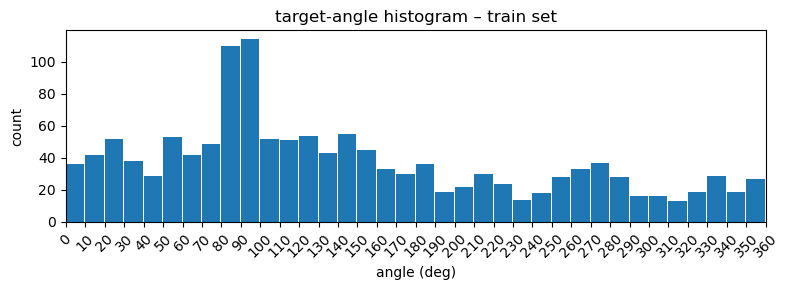

: 

: 

In [ ]:
import torch, math, matplotlib.pyplot as plt
from tqdm import tqdm

bin_edges = torch.arange(0, 361, 10)        # 10° grid: 0,10,20,…,360
hist      = torch.zeros(len(bin_edges)-1)   # CPU

with torch.no_grad():
    for pair in tqdm(train_loader, desc="scan train"):
        ang = torch.rad2deg(                       # ° in [0,360)
                torch.atan2(pair.y[:,1], pair.y[:,0])
        ) % 360
        hist += torch.histc(ang.cpu(),
                            bins=len(bin_edges)-1,
                            min=0, max=360)

plt.figure(figsize=(8,3))
plt.bar(bin_edges[:-1], hist, width=9.5, align='edge')
plt.xlabel("angle (deg)"); plt.ylabel("count"); plt.xticks(bin_edges)
# Make the x ticks diagonally readable
plt.xticks(rotation=45)
plt.xlim(0, 360)

plt.title("target‐angle histogram – train set")
plt.tight_layout(); plt.show()


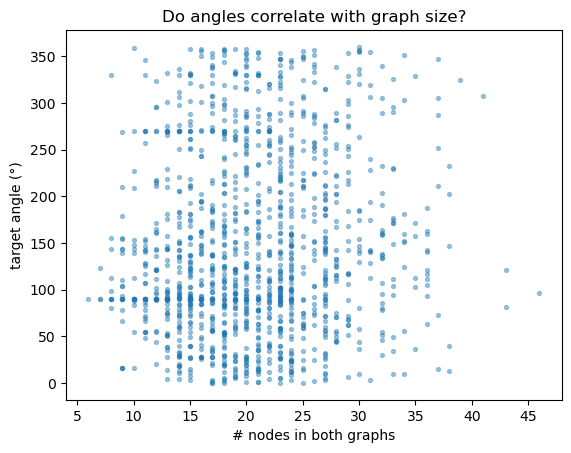

: 

: 

In [ ]:
xs, ys = [], []
for pair in train_dataset:                      # <-- iterate dataset directly
    # total atoms in both graphs
    xs.append(pair.x_s.size(0) + pair.x_t.size(0))

    ang = torch.rad2deg(torch.atan2(pair.y[0, 1], pair.y[0, 0])) % 360
    ys.append(float(ang))                      # scalar, so .item() / float() is fine

xs, ys = np.array(xs), np.array(ys)

plt.scatter(xs, ys, s=8, alpha=0.4)
plt.xlabel("# nodes in both graphs")
plt.ylabel("target angle (°)")
plt.title("Do angles correlate with graph size?")
plt.show()


Your figure looks like a solid ball of points: every angle from 0° → 360° occurs roughly equally often for almost every graph size (6 – 45 atoms in the two reactants).
That means

    Graph size alone carries essentially zero information about the
    angle you are trying to predict.
    A model that can only “see” #nodes would perform no better than chance.

    The dataset is probably not corrupted or shuffled – if graphs and
    angles had been mismatched you would often see strange vertical
    stripes (many identical angles for one size) or horizontal gaps.
    You don’t.

So the angle must depend on finer‐grained structural features
(atom types, bond orders, stereochemistry, …), not on molecule size or
count of heavy atoms. That’s encouraging: it means your GNN actually
has something non-trivial to learn – we just have to make sure
gradients really reach the encoder (which they do now) and perhaps give
it a richer message-passing architecture or more data.

scan train: 100%|██████████| 85/85 [00:00<00:00, 889.09it/s]



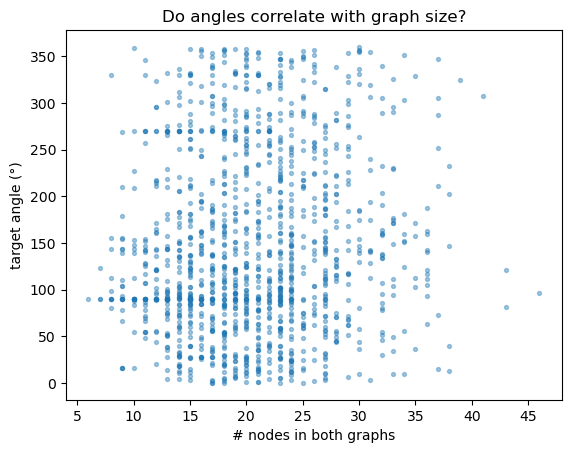

: 

: 

In [ ]:
xs, ys = [], []
with torch.no_grad():
    for pair in tqdm(train_loader, desc="scan train"):
        # how many separate graphs are in this batch?
        num_graphs = pair.y.size(0)            # == batch size

        # ----- total nodes per graph -------------------------------------
        for i in range(num_graphs):
            ns = (pair.x_s_batch == i).sum()   # nodes in source molecule i
            nt = (pair.x_t_batch == i).sum()   # nodes in target molecule i
            xs.append(int(ns + nt))

        # ----- angles -----------------------------------------------------
        ang = torch.rad2deg(torch.atan2(pair.y[:, 1], pair.y[:, 0])) % 360
        ys.extend(ang.tolist())                # one angle per graph

xs, ys = np.array(xs), np.array(ys)

plt.scatter(xs, ys, s=8, alpha=0.4)
plt.xlabel("# nodes in both graphs")
plt.ylabel("target angle (°)")
plt.title("Do angles correlate with graph size?")
plt.show()


In [ ]:
bad = 0
with torch.no_grad():
    for pair in train_loader:
        n = pair.y.norm(dim=-1)                  # ‖v‖
        bad += torch.count_nonzero( torch.abs(n-1) > 1e-3 )

print(f"{bad} / {len(train_loader.dataset)} targets deviate >1e-3 from unit length")


0 / 1356 targets deviate >1e-3 from unit length


: 

: 

In [ ]:
# sample
v = torch.tensor([[ 0.0, 1.0 ],          # expected  90°
                  [ 1.0, 1.0 ],          # expected  45°
                  [-1.0,-1.0 ]])         # expected -135°  or 225°
ang = torch.atan2(v[:,1], v[:,0])        # rad
print("rad:", ang.tolist())
print("deg mod 360:", (torch.rad2deg(ang) % 360).tolist())


rad: [1.5707963705062866, 0.7853981852531433, -2.356194496154785]
deg mod 360: [90.0, 45.0, 225.0]


: 

: 

: 

: 